## Exploration 15. OCR 🔍

<img src='https://editor.analyticsvidhya.com/uploads/57573OCR.png' height='600'>

### Table of Contents

### 1. Import Libraries

### 2. Prepare Dataset for Validation

### 3. Test Progress (Keras-ocr, Tesseract, Google OCR API)

* 3.1 Keras-ocr
* 3.2 Tesseract
* 3.3 Google OCR API

### 4. Summary of Test Results

### 5. Analysis of Results and Conclusions

* 5.1 Model Selection Criteria
* 5.2 Analysis of Results

### 6. Retrospection

***

### 1. Import Libraries

In [1]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as img

# keras-ocr
import keras_ocr

# tesseract
import pytesseract
from PIL import Image
from pytesseract import Output
import re

# Google OCR API
from google.cloud import vision
import io
from PIL import ImageDraw

### 2. Prepare Dataset for Validation

### 2.1 Service Planning

* 의약품 패키지는 환자의 복용 용이성을 위해 글자의 크기와 표현이 단순화되어있다.
* 그러나 시각장애인을 위한 점자 패키지는 많지 않다.
* OCR 서비스 만으로는 도움이 되지 않을 수 있으나, OCR 시스템을 통해 읽힌 의약품명이 소리로 전달될 수 있다면 도움이 될 것 같다.

### 2.2 Building the Dataset

In [2]:
data_path = os.getenv('HOME')+'/aiffel/ocr_python/image/'

In [3]:
images_path = glob.glob(data_path+"*.jpg")
images_path

['/aiffel/aiffel/ocr_python/image/3.jpg',
 '/aiffel/aiffel/ocr_python/image/5.jpg',
 '/aiffel/aiffel/ocr_python/image/8.jpg',
 '/aiffel/aiffel/ocr_python/image/11.jpg',
 '/aiffel/aiffel/ocr_python/image/10.jpg',
 '/aiffel/aiffel/ocr_python/image/4.jpg',
 '/aiffel/aiffel/ocr_python/image/7.jpg',
 '/aiffel/aiffel/ocr_python/image/1.jpg',
 '/aiffel/aiffel/ocr_python/image/2.jpg',
 '/aiffel/aiffel/ocr_python/image/13.jpg',
 '/aiffel/aiffel/ocr_python/image/14.jpg',
 '/aiffel/aiffel/ocr_python/image/6.jpg',
 '/aiffel/aiffel/ocr_python/image/15.jpg',
 '/aiffel/aiffel/ocr_python/image/12.jpg',
 '/aiffel/aiffel/ocr_python/image/9.jpg']

* 15개의 의약품 이미지를 가져온다.

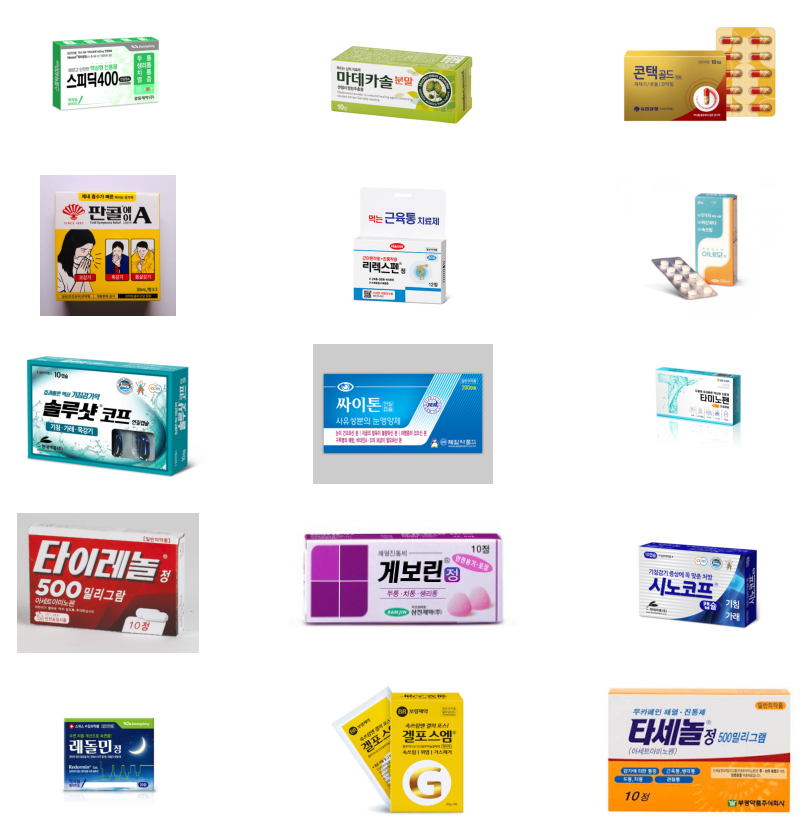

In [4]:
plt.figure(figsize=(15, 15))

for i, image in enumerate(images_path,1):
    plt.subplot(5, 3, i)
    plt.imshow(img.imread(image))
    plt.axis('off')

### 3. Test Progress (Keras-ocr, Tesseract, Google OCR API)

### 3.1 Keras-ocr

In [5]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드 받게 된다.
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [6]:
images = [keras_ocr.tools.read(im) for im in images_path]
predictions = [pipeline.recognize([im]) for im in images_path]

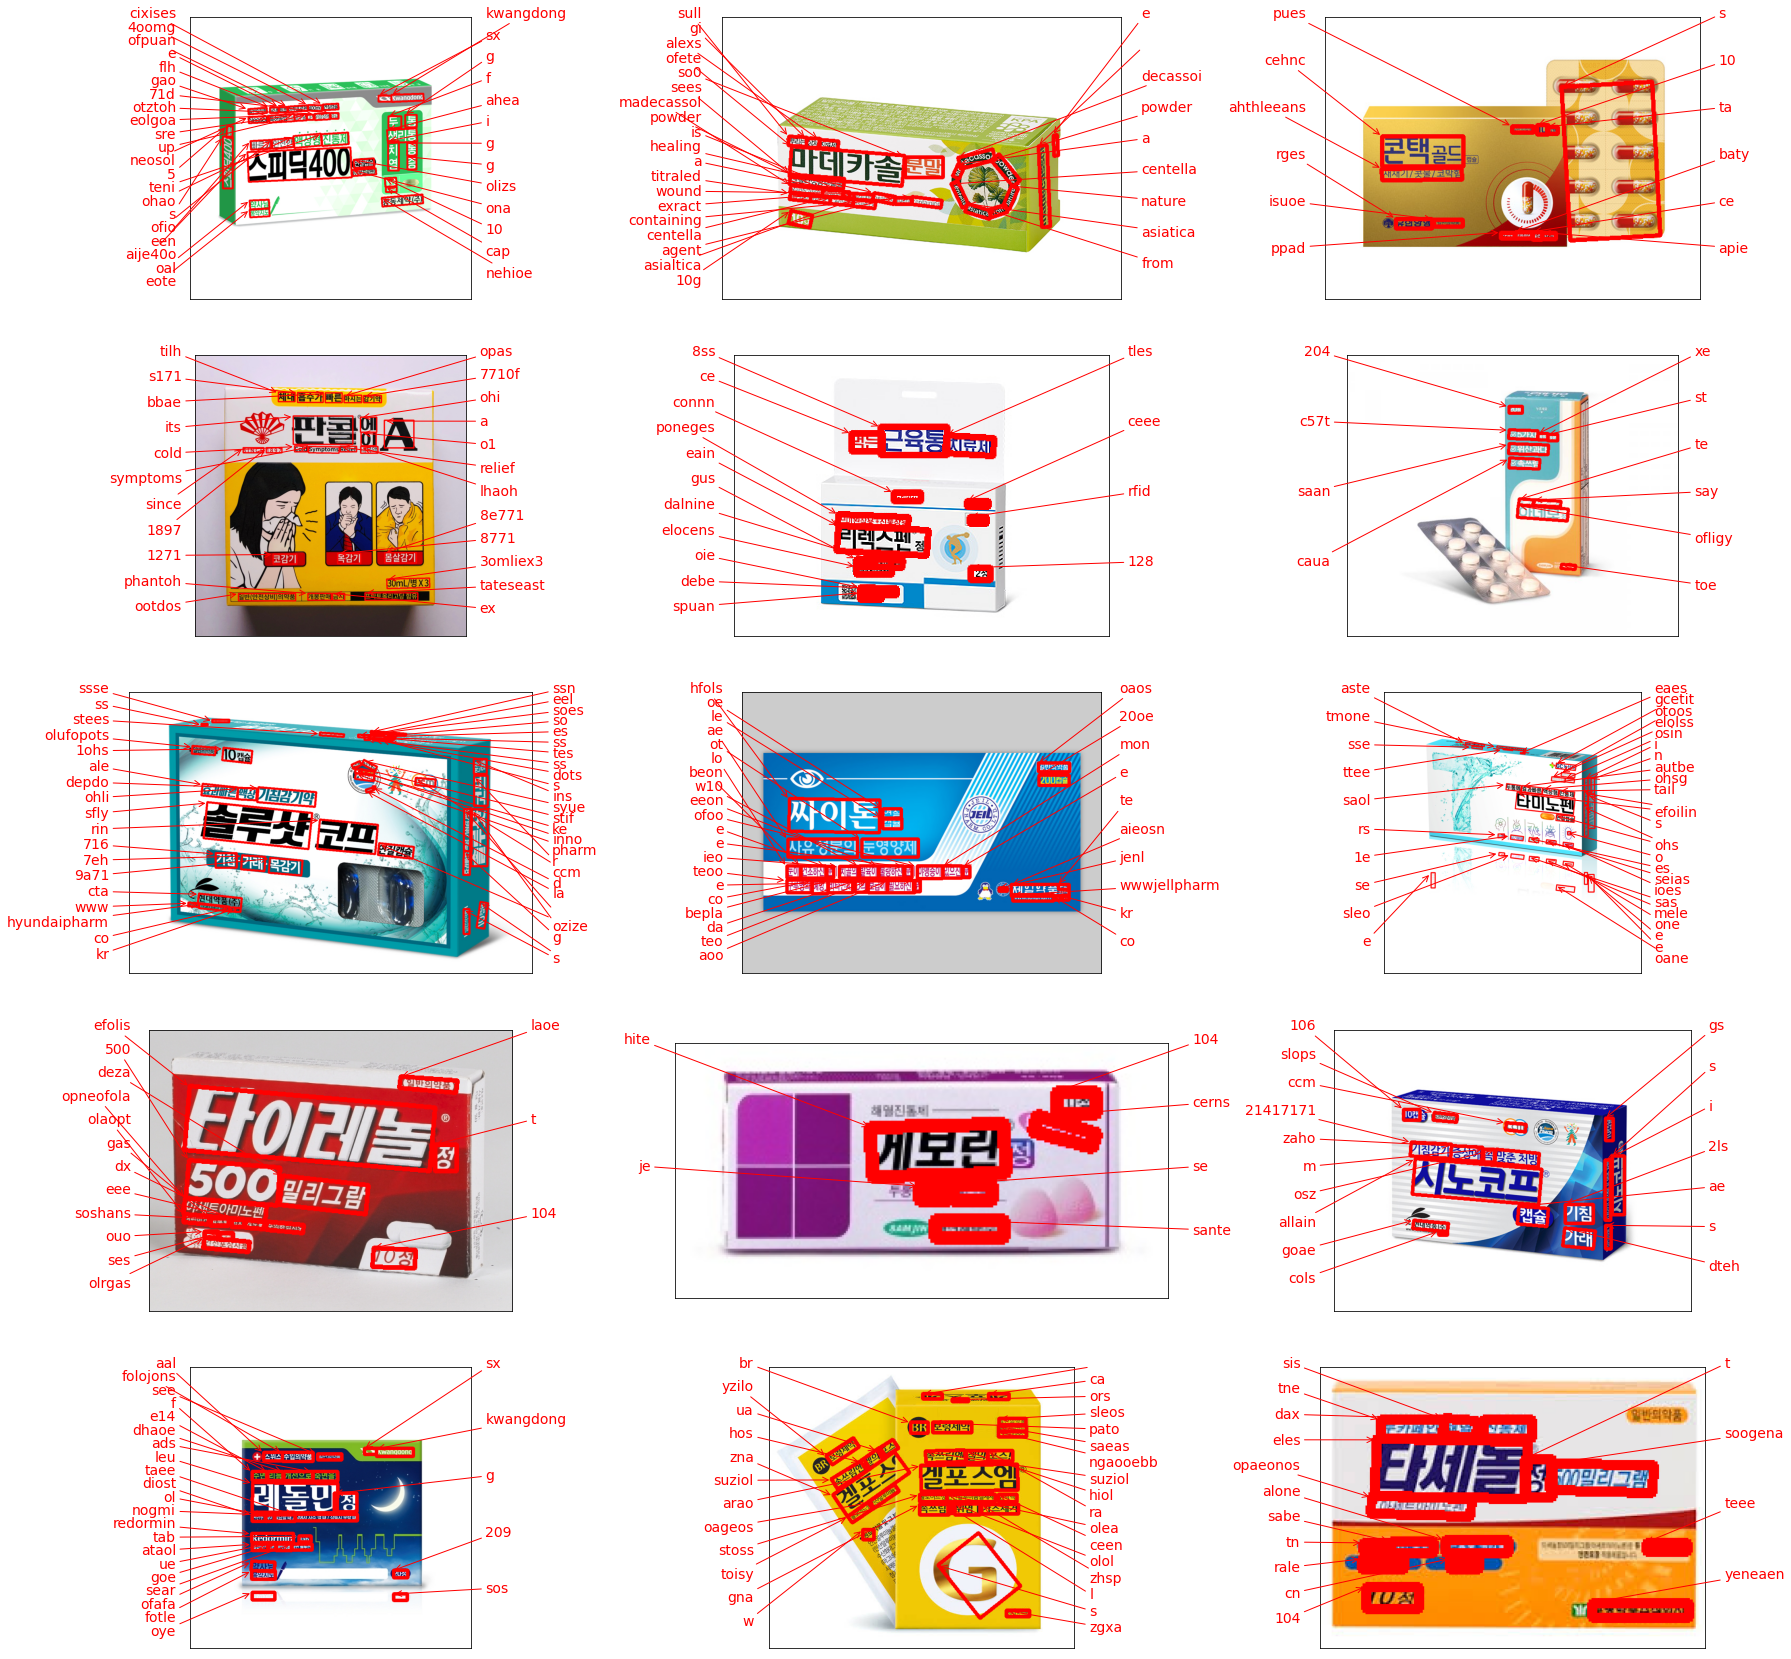

In [7]:
fig, axs = plt.subplots(5, 3, figsize=(30, 30))
for a in range(len(axs)):
    for b in range(len(axs[a])):
        keras_ocr.tools.drawAnnotations(image=images[3*a+b], 
                                    predictions=predictions[3*a+b][0], ax=axs[a,b])

* 정교하게 인식한 듯 보이지만 한글 지원이 되지 않아 비슷한 알파벳으로 인식하고 있다. 

### 3.2 Tesseract

### 3.2.1 Character Detection and Image Cropping

**OCR Engine modes(–oem):**

* 0 - Legacy engine only.
* 1 - Neural nets LSTM engine only.
* 2 - Legacy + LSTM engines.
* 3 - Default, based on what is available.

**Page segmentation modes(–psm):**

* 0 - Orientation and script detection (OSD) only.
* 1 - Automatic page segmentation with OSD.
* 2 - Automatic page segmentation, but no OSD, or OCR.
* 3 - Fully automatic page segmentation, but no OSD. (Default)
* 4 - Assume a single column of text of variable sizes.
* 5 - Assume a single uniform block of vertically aligned text.
* 6 - Assume a single uniform block of text.
* 7 - Treat the image as a single text line.
* 8 - Treat the image as a single word.
* 9 - Treat the image as a single word in a circle.
* 10 - Treat the image as a single character.
* 11 - Sparse text. Find as much text as possible in no particular order.
* 12 - Sparse text with OSD.
* 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

In [8]:
def recognize_images(image_path='./images/sample.jpg', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")

            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1

    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [9]:
# 테서랙트로 잘린 이미지에서 단어 인식하기
save_dir = os.getenv('HOME')+'/aiffel/ocr_python/medicine/'

for img in images_path:
    print(f'[{img}]')
    try:
        recognize_images(os.path.join(data_path, img), save_dir)
    except:
        print(f'Cannot recognize characters from {img}')

[/aiffel/aiffel/ocr_python/image/3.jpg]
Cannot recognize characters from /aiffel/aiffel/ocr_python/image/3.jpg
[/aiffel/aiffel/ocr_python/image/5.jpg]
[바드

대

니더

뇨

[

술

문밑

늘

라종


130603966

이

"004000 「1621100

39600

나“

[6입

0 닥

나

0


0

0912},

트 니조 란  0

Done
[/aiffel/aiffel/ocr_python/image/8.jpg]

Done
[/aiffel/aiffel/ocr_python/image/11.jpg]
제내

음 -




마시는

감기약

그랜

2

익 | 9 (-

Ｌ

] 89 /

( (101

5\71[0101115

{ㅇ616}

나

트인

개



Done
[/aiffel/aiffel/ocr_python/image/10.jpg]

ㄷ=ㅋㅠㅎㄷ


ㄷ니빨작용 *진통작용

(1110

리렁

|렉스편

@


Done
[/aiffel/aiffel/ocr_python/image/4.jpg]

Done
[/aiffel/aiffel/ocr_python/image/7.jpg]

~

기

!

~

“1


.

ㅣ


Done
[/aiffel/aiffel/ocr_python/image/1.jpg]
0

7

"


브


;

공이

의

발유(|


이

불2

(0)

하신

누

|

0[맹증0

두명

0


에망

비타민) ㆍ

)의

보급이

썸요

0

신돕


, 제일

시 56

=

내

저

겨 0

11


여겨,


이아 빠 새

Done
[/aiffel/aiffel/ocr_python/image/2.jpg]
Cann

### 3.3 Google OCR API

In [10]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [11]:
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'


# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for img in images_path:
    print(f'[{img}]')
    detect_text(os.path.join(data_path, img))
    print()

total 4880
drwxr-xr-x  2 root root    4096 Feb 13 22:33  activation
drwxr-xr-x  4 root root    4096 Feb 17 00:40  bert_qna
drwxr-xr-x  4 root root    4096 Feb  9 05:37  camera_sticker
drwxr-xr-x  4 root root    4096 Jan 12 05:53  cat_vs_dog
drwxr-xr-x  2 root root    4096 Feb  3 00:28  chest_xray
drwxr-xr-x  2 root root    4096 Jan  3 01:04  data_preprocess
drwxr-xr-x  3 root root    4096 Dec 31 05:48  data_represent
drwxr-xr-x  2 root root    4096 Jan  5 01:30  data_visualization
drwxr-xr-x 15 root root    4096 Feb 14 12:11  dcgan_newimage
drwxr-xr-x 15 root root    4096 Feb  8 03:46  detectron2_repo
-rw-r--r--  1 root root  235779 Mar  6 06:34 '[E-14]MovieRecommendation.ipynb'
-rw-r--r--  1 root root 4100228 Mar  6 10:45 '[E-15]OCR-Copy1.ipynb'
-rw-r--r--  1 root root  523139 Mar  6 11:10 '[E-15]OCR.ipynb'
drwxr-xr-x  3 root root    4096 Feb  9 11:35  histogram
drwxr-xr-x  2 root root    4096 Feb 18 01:28  information_theory
drwxr-xr-x  4 root root    4096 Feb  9 05:38  kaggle_kakr_h

### 4. Summary of Test Results

* 결과 비교 함수 생성 후 확인

In [12]:
def compare_ocr(img):
    print('[keras-ocr]')
    idx = images_path.index(img)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=predictions[idx][0])
    plt.show()
    print('[Tesseract]')
    recognize_images(os.path.join(data_path, img), save_dir)
    print('[Google OCR]')
    detect_text(os.path.join(data_path, img))

[keras-ocr]


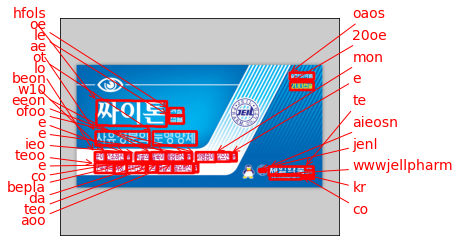

[Tesseract]
0

7

"


브


;

공이

의

발유(|


이

불2

(0)

하신

누

|

0[맹증0

두명

0


에망

비타민) ㆍ

)의

보급이

썸요

0

신돕


, 제일

시 56

=

내

저

겨 0

11


여겨,


이아 빠 새

Done
[Google OCR]
Texts:

"일반의약품
200캡슐
싸이톤
캡슐
사유성분의 눈영양제
눈이 건조하신 분 | 치골의 발육이 불량하신 분 | 야맹중이 있으신 분
구루병의 예방, 비타민A· D의 보급이 필요하신 분
@ 제일약품사
www.jeilpharm.co.kr
푸식
PHA
"

"일반"

"의약품"

"200"

"캡슐"

"싸이"

"톤"

"캡슐"

"사유"

"성분"

"의"

"눈"

"영양제"

"눈"

"이"

"건조"

"하신"

"분"

"|"

"치골"

"의"

"발육"

"이"

"불량"

"하신"

"분"

"|"

"야맹"

"중"

"이"

"있으신"

"분"

"구루병"

"의"

"예방"

","

"비타민"

"A"

"·"

"D"

"의"

"보급"

"이"

"필요"

"하신"

"분"

"@"

"제일"

"약품"

"사"

"www.jeilpharm.co.kr"

"푸식"

"PHA"
bounds: (472,222),(470,280),(454,279),(456,221)


In [13]:
compare_ocr('/aiffel/aiffel/ocr_python/image/1.jpg')

[keras-ocr]


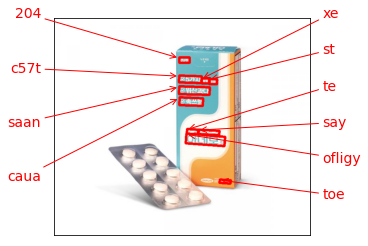

[Tesseract]

Done
[Google OCR]
Texts:

"20경
누세요
C5가지 복합 성분
@위산과다
@ 속쓰림
복 합 제 산 제
아네모정
CAMJIN O
"

"20"

"경"

"누"

"세요"

"C5"

"가지"

"복합"

"성분"

"@"

"위산"

"과다"

"@"

"속쓰림"

"복"

"합"

"제"

"산"

"제"

"아네"

"모정"

"CAMJIN"

"O"
bounds: (465,456),(483,457),(482,466),(464,465)


In [14]:
compare_ocr('/aiffel/aiffel/ocr_python/image/4.jpg')

[keras-ocr]


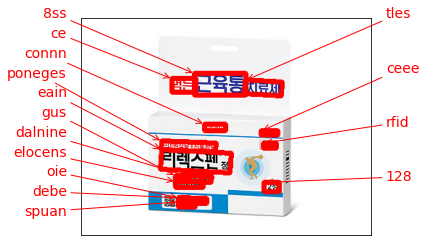

[Tesseract]

ㄷ=ㅋㅠㅎㄷ


ㄷ니빨작용 *진통작용

(1110

리렁

|렉스편

@


Done
[Google OCR]
Texts:

"먹는 근육통 치료제
Hanmi
AFID
근이완작용·진통작용
리렉스펜정
근
12정
"

"먹는"

"근육통"

"치료제"

"Hanmi"

"AFID"

"근"

"이완"

"작용"

"·"

"진통"

"작용"

"리"

"렉스"

"펜정"

"근"

"12"

"정"
bounds: (265,228),(269,228),(269,239),(265,239)


In [15]:
compare_ocr('/aiffel/aiffel/ocr_python/image/10.jpg')

[keras-ocr]


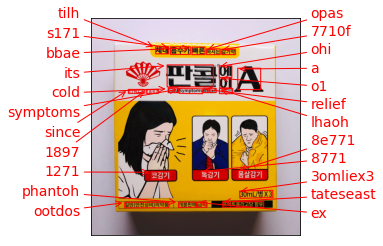

[Tesseract]
제내

음 -




마시는

감기약

그랜

2

익 | 9 (-

Ｌ

] 89 /

( (101

5\71[0101115

{ㅇ616}

나

트인

개



Done
[Google OCR]
Texts:

"체내 흡수가 빠른 마시는 감기약
판콜에A
SINCE 1897
Cold Symptoms Relief LHEOH
코감기
목감기
몸살감기
30mL/병 X3
일반(안전상비)의 약품
개봉판매 금지
프락토올리고당 함유
"

"체내"

"흡수"

"가"

"빠른"

"마시는"

"감기약"

"판콜"

"에"

"A"

"SINCE"

"1897"

"Cold"

"Symptoms"

"Relief"

"LHEOH"

"코"

"감기"

"목"

"감기"

"몸살"

"감기"

"30mL"

"/"

"병"

"X3"

"일반"

"("

"안전"

"상비"

")"

"의"

"약품"

"개봉"

"판매"

"금지"

"프"

"락토"

"올리고당"

"함유"
bounds: (1080,1222),(1134,1222),(1134,1251),(1080,1251)


In [16]:
compare_ocr('/aiffel/aiffel/ocr_python/image/11.jpg')

### 5. Analysis of Results and Conclusions

### 5.1 Model Selection Criteria

* 기획한 서비스가 제대로 구현되기 위해서는 아래의 조건을 만족하는 모델을 선정하는 것이 타당하다.
  * 제품명 검출 여부
  * 제형, 함량 등의 정보 검출 여부
  * 언제 쓰는 약인지에 대한 정보 검출 여부
* O, X 평가 순서 : 제품명 검출 여부 / 제형, 함량 등의 정보 검출 여부 / 언제 쓰는 약인지에 대한 정보 검출 여부

| 이미지/모델 | Keras-ocr | Tesseract | Google OCR |
| :---: | :---: | :---: | :---: |
| 1 | X/X/X | X/X/X | O/O/O |
| 2 | X/X/X | X/X/X | O/O/O |
| 3 | X/X/X | X/X/X | O/O/O |
| 4 | X/X/X | X/X/X | O/O/O |
| 5 | X/X/X | X/X/X | O/O/O |
| 6 | X/X/X | X/X/O | O/O/O |
| 7 | X/X/X | X/X/X | O/O/O |
| 8 | X/X/X | X/X/X | O/O/O |
| 9 | X/X/X | X/O/X | O/O/O |
| 10 | X/X/X | X/X/O | O/O/O |
| 11 | X/X/X | X/O/O | O/O/O |
| 12 | X/X/X | X/O/X | O/O/O |
| 13 | X/X/X | X/X/X | O/O/O |
| 14 | X/X/X | X/X/X | O/O/O |
| 15 | X/X/X | X/X/X | O/O/O |

### 5.2 Analysis of Results

* 고민할 필요도 없이 Google OCR의 결과가 제일 좋았다. 
* 다른 모델에 대한 고려가 필요하지 않은 수준이다.
* 아무래도 패키지의 내용이 대부분 한글이다 보니 한글에 대한 학습이 잘 되어있는 모델의 결과가 좋을 수 밖에 없을 것이다.

### 6. Retrospection

### 6.1 What was difficult

* 모델마다 반환되는 결과값이 달라 비교가 조금 힘들었다. 

### 6.2 What I want to know more about

* 패키지가 전부 영어로 되어있는 외국의 의약품이라면 결과가 조금 다르게 나오지 않았을까하는 생각이 든다.

### 6.3 Self-Resolution

* 처음 기획은 시각 장애인들을 위해 의약품 구별이 가능하도록 하는 기능을 구현하는 것이었다.
* 결과로는 Google OCR을 사용하는 것이 가장 타당하다고 판단되었으나,
* 비용적으로나 시간적으로나 효율성을 따지자면
* 위 기능을 구현하는 것보다 패키지에 점자를 도입하는 것이 더 나을 것 같다는 생각이 들었다. 🤣